# First sketch to create Perceptually uniform divergent monotonic colormaps

In [1]:
#import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import viscm

In [3]:
# sRGB corners: a' goes from -37.4 to 45
# AP_LIM = (-38, 46)
# b' goes from -46.5 to 42
# BP_LIM = (-47, 43)
# J'/K goes from 0 to 100
# JP_LIM = (-1, 101)

In [4]:
import numpy as np
from matplotlib.colors import ListedColormap
from colorspacious import cspace_converter, deltaE


def divergent_monotonic_cmap(Jp_min=20, Jp_max=95, points=None, name='my_colormap',
                             max_iter = 100, clipping=False, verbose=True,
                             uniform_space='CAM02-UCS', N=256, step=0.01, return_deltaE=False):
    """
    Jp_min, Jp_max = linear mapping for lightness
    points = list of (a', b') pairs for (e.g 3 pairs for min, gray, max)
             points = ((0, -25), (0, 0), (-25, 0))
    step = change in lightness over last invalid value in Lp
    
    
    """
    
    # convert from 
    UCS_to_sRGB1 = cspace_converter(uniform_space, 'sRGB1')
    
    if points is None:
        points = ((0, -25), (0, 0), (-25, 0))
        
    # Check that N is divisible to m bins
    m = len(points)-1
    assert not N % m
    bin_size = N // m
    
    lt_0 = True
    gt_1 = True
    iter_round = 0
    while (lt_0 or gt_1) and iter_round < max_iter:
        Jp = np.linspace(Jp_min, Jp_max, N)
        
        
        ap = []
        bp = []
        for ix, ((ai, bi), (aj, bj)) in enumerate(zip(points[:-1], points[1:])):
            # Include endpoint for last step
            endpoint = m == ix
            ap.append(np.linspace(ai, aj, bin_size, endpoint=endpoint))
            bp.append(np.linspace(bi, bj, bin_size, endpoint=endpoint))
        
        ap = np.concatenate(ap)
        bp = np.concatenate(bp)
        Jpapbp = np.column_stack((Jp,ap,bp))

        rgb = UCS_to_sRGB1(Jpapbp)
        
        lt_0 = np.sum(rgb < 0)
        if lt_0:
            positions = np.flatnonzero(np.sum(rgb < 0, axis=1))
            Jp_min = Jp[positions.max()]+step

        gt_1 = np.sum(rgb > 1)
        if gt_1:
            positions = np.flatnonzero(np.sum(rgb > 1, axis=1))
            Jp_max = Jp[positions.min()]-step

        if Jp_min > Jp_max:
            raise ValueError("No solution with current Lp ap and bp pairs")

        iter_round += 1
    
    if clipping and (lt_0 or gt_1):
        if verbose:
            print("Maximum iteration: No solution with current Lp ap and bp pairs\nReturning clipped cmap")
        rgb = np.clip(rgb, 0, 1)
        
    if verbose:
        print("Number of iteration round(s) = {}".format(iter_round))
        ptp_value = np.ptp(deltaE(rgb[:-1, :], rgb[1:, :]))
        print("Peak to peak in deltaE = {:.2g}".format(ptp_value))
    
    # Create colormap
    assert rgb.min() > 0
    assert rgb.max() < 1
    cmap = ListedColormap(rgb, name=name)
    
    if return_deltaE:
        deltaE_values = deltaE(rgb[:-1, :], rgb[1:, :], uniform_space=uniform_space)
        return cmap, deltaE_values
    else:
        return cmap

# Currently only linear function is implemented

In [5]:
# For equal deltaE specify r equal for both 'colors'

r = 25

color1 = (0, -r) # Blue
gray = (0, 0)

# reddish = color with 0.7 of pure red and 0.3 pure yellow
#  >> 1 pure red vs p=0.3/0.7 pure yellow
# r1 = r/sqrt(1+p^2)
# r2 = p * r1
p = 0.3/0.7
r1 = r/np.sqrt(1+p**2)
r2 = p * r1

color2 = (r1, r2) # Reddish 
points = (color1, gray, color2)


my_cmap = divergent_monotonic_cmap(points=points)

Number of iteration round(s) = 38
Peak to peak in deltaE = 3.5e-13


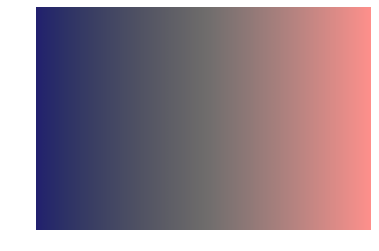

In [6]:
plt.imshow(np.linspace(0,1,256)[np.newaxis, ...], cmap=my_cmap, aspect='auto')
plt.gca().set_axis_off()

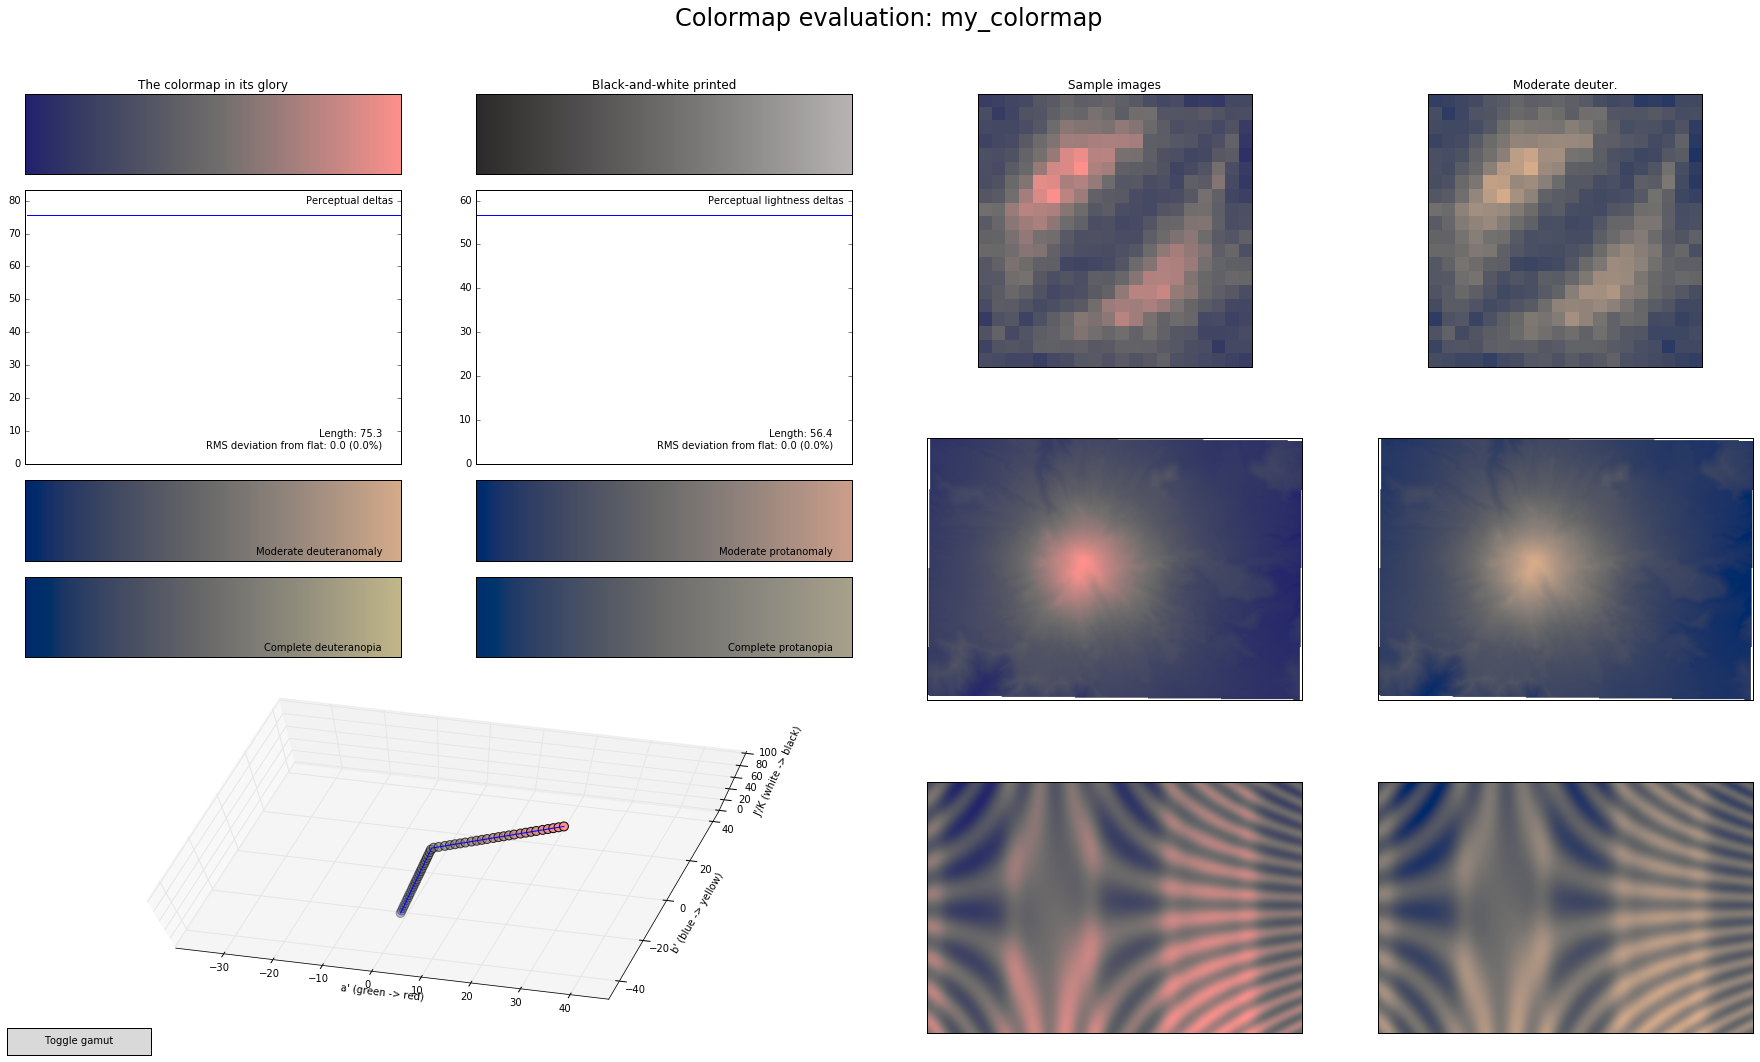

In [7]:
viscm.viscm(my_cmap)
fig = plt.gcf()
fig.set_size_inches(25, 15)

In [8]:
# For equal deltaE specify r equal for both 'colors'

r = 25

color1 = (0, -r) # Blue
gray = (0, 0)
color2 = (-r, 0) # Greenish 
points = (color1, gray, color2)


my_cmap2 = divergent_monotonic_cmap(points=points)

Number of iteration round(s) = 15
Peak to peak in deltaE = 2.6e-12


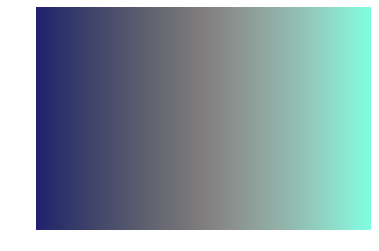

In [10]:
plt.imshow(np.linspace(0,1,256)[np.newaxis, ...], cmap=my_cmap2, aspect='auto')
plt.gca().set_axis_off()

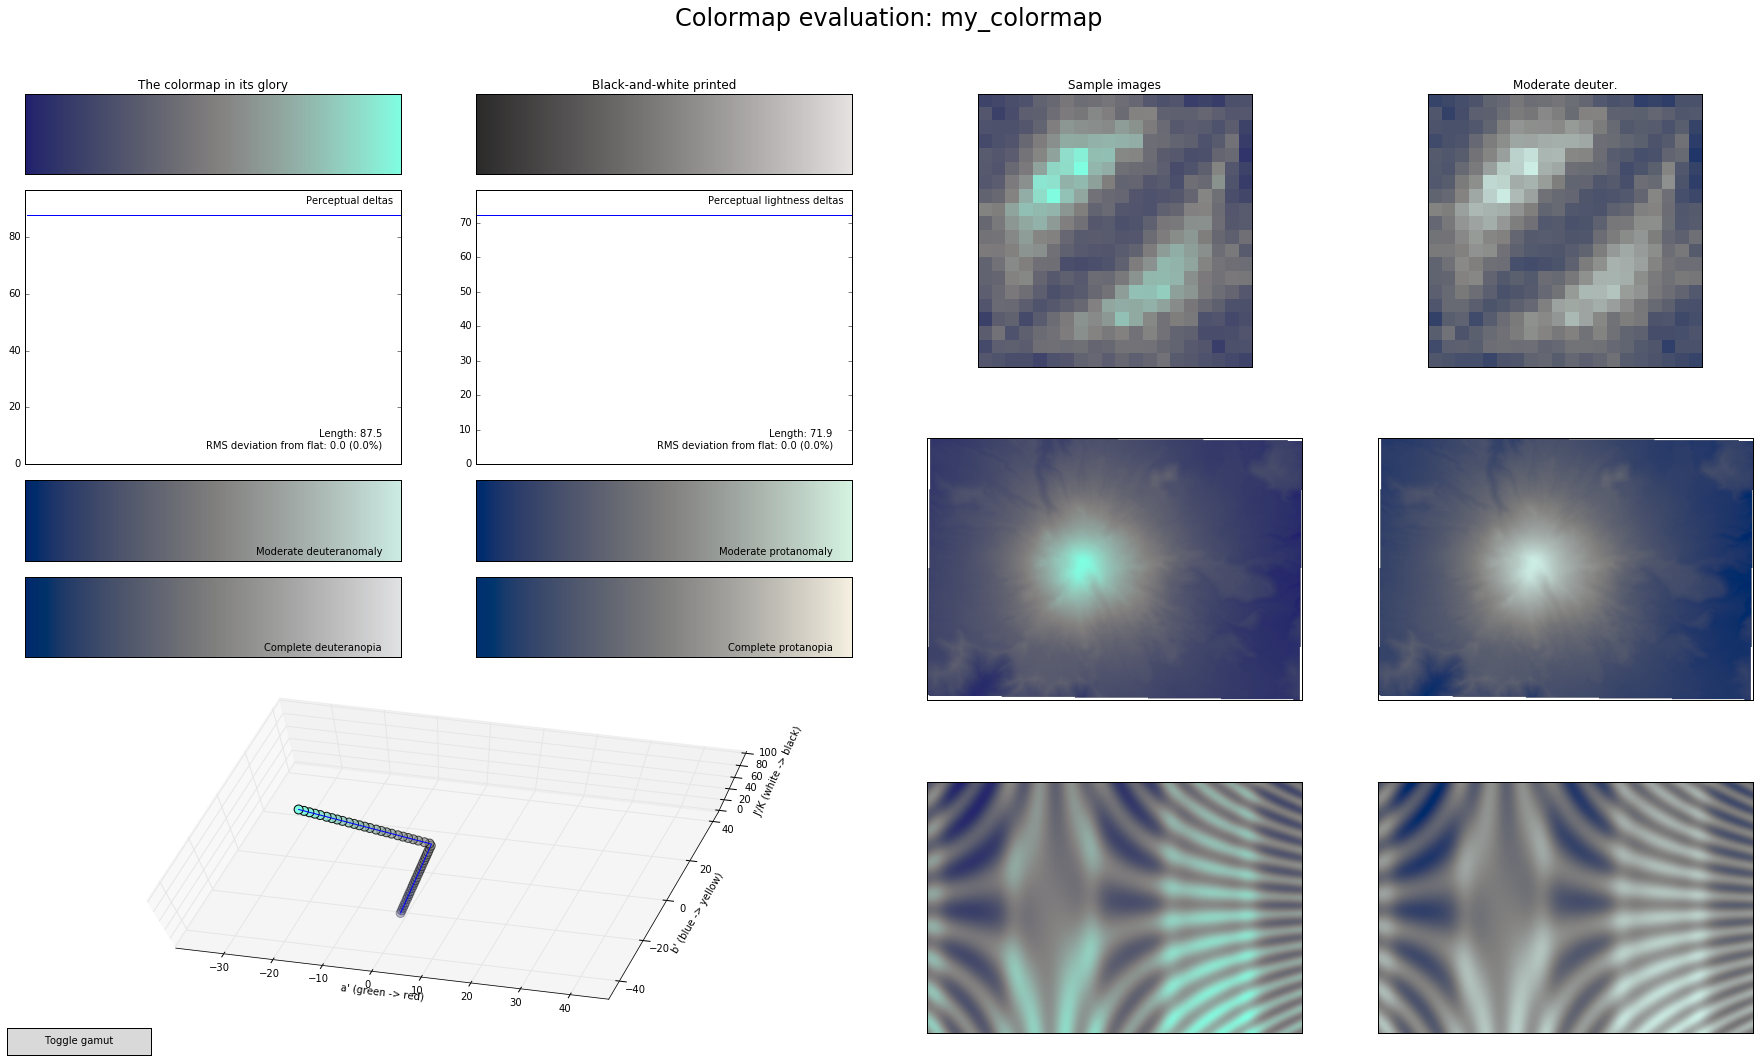

In [12]:
viscm.viscm(my_cmap2)
fig = plt.gcf()
fig.set_size_inches(25, 15)